#FEDS(Data analysis problem)
ANSWERS are marked below in bold font. This is a code walk-through along with explanation

In [7]:
import requests

URL = "https://www.w3schools.com/xml/simple.xml"

response = requests.get(URL)
with open('feed.xml', 'wb') as file:
    file.write(response.content)

ProxyError: HTTPSConnectionPool(host='www.w3schools.com', port=443): Max retries exceeded with url: /xml/simple.xml (Caused by ProxyError('Cannot connect to proxy.', OSError('Tunnel connection failed: 403 Forbidden',)))

PROBLEM OVERVIEW-
Data Analysis and Visualization ((Data: Order_Shipments.csv, Shipment_Deliveries.csv)
As Amazon Fulfillment Execution, one of our core responsibilities is to make sure that shipments are delivered on time to the customers. For this purpose, we work very closely with our carriers to help them attain ad maintain a high level of on-time delivery performance. As part of this effort, you are tasked with measuring the on-time delivery performance of Amazon's contracted parcel carriers and creating actionable intelligence for operational leaders.

Director of Outbound Transportation has defined the following as key requirements for this metric:
1. Every carrier must have an on-time delivery performance score for each week of deliveries.
2. This score should reflect carriers' performance in terms of (in the order of importance - most important at the top):
a. Existence of a customer complaint about the delivery experience (other than lateness)
b. Delivery on or before promised delivery date and time
c. Lateness (for those deliveries that are late by more than 1/2 hour)
d. Earliness (for those deliveries that are early by more than 6 hours)
3. The score should be normalized to be between 0 and 100. Highest score should reflect the best
performing carrier. and carriers must be ranked by the score for the score of the latest week (highest at the top).
4. The metric should show past 13 weeks of scores at the weekly level in tabular form as well as
the Week-Over-Week change in score for the last week.
5. Overall delivery performance score (i.e. aggregate of all carriers) should be shown in a graph for
the past 13 weeks.

DATA OVERVIEW:-
Historical delivery data is provided in the following files:
Order_Shipments.csv: This file provides historical data on customer orders, shipments (an order can have multiple shipments) and their promised delivery date and time. Fields:
Order_Datetime
, Customer_Location_ID
, Order_ID
, Shipment_ID
, Promised_Delivery_Datetime.
ii. Shipment_Deliveries.csv: This file provides historical data on customer shipments, carriers, actual
delivery date and time, and customer complaint counts. Each shipment is delivered by a single carrier.
Fields:
Shipment_ID
, Carrier_ID
, Actual_Delivery_Datetime
, Shipment_Complaint_Count    

PROBLEM TASK:-
a) Please develop a computer application that reads the given files and produces the required output as shown above. You are welcome to use any framework/toolchain you would like as long as it is publicly available without a license. If you use R or Python you get extra credit since these are the languages we are currently utilizing.
b) Given the provided data, develop a computer application that automatically identifies specific customer locations that have significantly difference overall performance than the rest of the customer landscape.

STEP 1: DATASET ER MODEL

In [1]:
#Import the libraries
from IPython.display import Image
import pandas as pd # dataframes
import numpy as np # algebra & calculus
import matplotlib.pyplot as plt # plotting

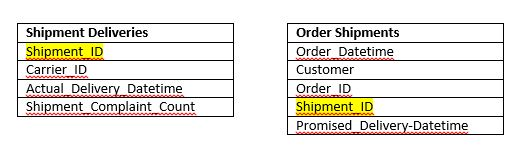

In [2]:
Image(filename='Capture.JPG') 

STEP2:  We will take a look at the dataset and merge both the dataset

In [3]:
sdev = pd.read_csv('ShipmentDeliveries.csv')# Stores the shipment deliveries
sdev.head()

,Shipment_ID,Carrier_ID,Actual_Delivery_Datetime,Shipment_Complaint_Count
0,5363,GNU LOGISTICS,16-02-06 18:44,0
1,7411,INTERBOX,16-02-08 16:14,0
2,12533,INTERBOX,16-06-24 15:31,0
3,3982,NaN,16-10-24 15:35,0
4,1365,INTERBOX,16-07-08 17:45,0


In [4]:
oship = pd.read_csv('OrderShipments.csv')# Stores the order shipment
oship.head()

,Order_Datetime,Customer_Location_ID,Order_ID,Shipment_ID,Promised_Delivery_Datetime
0,16-06-11 09:40,A672,9762,14787,2016-06-13 20:00:00
1,16-12-03 16:40,A243,3776,5728,2016-12-07 20:00:00
2,16-08-17 05:16,A782,2042,3136,2016-08-21 20:00:00
3,16-07-31 19:47,A120,4417,6703,2016-08-03 20:00:00
4,16-10-24 11:12,A669,1750,2675,2016-10-26 20:00:00


In [5]:
dat=pd.merge(sdev,oship, on='Shipment_ID') # Merge dataset on Shipment_ID
dat.head()

,Shipment_ID,Carrier_ID,Actual_Delivery_Datetime,Shipment_Complaint_Count,Order_Datetime,Customer_Location_ID,Order_ID,Promised_Delivery_Datetime
0,5363,GNU LOGISTICS,16-02-06 18:44,0,16-02-02 07:13,A879,3542,2016-02-06 20:00:00
1,7411,INTERBOX,16-02-08 16:14,0,16-02-04 22:57,A52,4879,2016-02-08 20:00:00
2,12533,INTERBOX,16-06-24 15:31,0,16-06-21 21:26,A564,8254,2016-06-24 20:00:00
3,3982,NaN,16-10-24 15:35,0,16-10-22 16:13,A188,2622,2016-10-24 20:00:00
4,1365,INTERBOX,16-07-08 17:45,0,16-07-04 23:08,A157,864,2016-07-08 20:00:00


STEP 3: Here we will calculate
    Delivery_Time=Promised_Delivery_Datetime-Actual_Delivery_Datetime
    Delivery_beforeTime= If Delivery_Time is greater than 0
    Lateness= If Delivery_Time is negative and less than 30 minutes(-0.5X60X60 seconds)
    Earliness= If Delivery_Time is negative and less than 6 hours(-6X60X60 seconds)
    Cust_comp_notlate= (Shipment_Complaint_Count-Lateness). When Lateness is 0 the value is just the Shipment_Complaint_Count.       
    If lateness value is 1 and we have Shipment_complaint_count of 1 and more, I have assumed that count of 1 is due to             lateness. So I have substracted from Shipment_Complaint_Count-Lateness if its is 1 or more.

In [6]:
dat.Carrier_ID.fillna('X', inplace=True) # Here carriers which are Null are replaced with X
#Convert object data type to datetime64
dat['Order_Datetime'] =  pd.to_datetime(dat['Order_Datetime'],yearfirst=True)
dat['Actual_Delivery_Datetime'] =  pd.to_datetime(dat['Actual_Delivery_Datetime'],yearfirst=True)
dat['Promised_Delivery_Datetime'] =  pd.to_datetime(dat['Promised_Delivery_Datetime'])
#Delivery time stores the before time delivery as postive value and after time as negative value 
dat['Delivery_Time'] = (dat['Promised_Delivery_Datetime']-dat['Actual_Delivery_Datetime']).astype('timedelta64[s]')
#Covert Delivery_beforeTime to 1(If delivered before time) and 0(If delivered after time)
dat['Delivery_beforeTime']=(dat['Delivery_Time']>=0)*1
dat['Lateness']=(dat['Delivery_Time']<-0.5*60*60)*1
dat['Earliness']=(dat['Delivery_Time']>6*60*60)*1
#Cust_comp_notlate stores a customer complaint count about the delivery experience (other than lateness)
dat['Cust_comp_notlate'] =(dat['Shipment_Complaint_Count']-dat['Lateness'])*((dat['Shipment_Complaint_Count']-dat['Lateness'])>0)
#Get the week number of each date.
#Note: From January-1-2016 to January-9-2016 is considered a week 1. Weeks are from Saturday to Sunday
dat['Actual_Delivery_Week'] =  pd.to_datetime(dat['Actual_Delivery_Datetime']).dt.week
print("Datatypes of each column-\n",dat.dtypes)
dat.head()

Datatypes of each column-
 Shipment_ID                            int64
Carrier_ID                            object
Actual_Delivery_Datetime      datetime64[ns]
Shipment_Complaint_Count               int64
Order_Datetime                datetime64[ns]
Customer_Location_ID                  object
Order_ID                               int64
Promised_Delivery_Datetime    datetime64[ns]
Delivery_Time                        float64
Delivery_beforeTime                    int64
Lateness                               int64
Earliness                              int64
Cust_comp_notlate                      int64
Actual_Delivery_Week                   int64
dtype: object


,Shipment_ID,Carrier_ID,Actual_Delivery_Datetime,Shipment_Complaint_Count,Order_Datetime,Customer_Location_ID,Order_ID,Promised_Delivery_Datetime,Delivery_Time,Delivery_beforeTime,Lateness,Earliness,Cust_comp_notlate,Actual_Delivery_Week
0,5363,GNU LOGISTICS,2016-02-06 18:44:00,0,2016-02-02 07:13:00,A879,3542,2016-02-06 20:00:00,4560.0,1,0,0,0,5
1,7411,INTERBOX,2016-02-08 16:14:00,0,2016-02-04 22:57:00,A52,4879,2016-02-08 20:00:00,13560.0,1,0,0,0,6
2,12533,INTERBOX,2016-06-24 15:31:00,0,2016-06-21 21:26:00,A564,8254,2016-06-24 20:00:00,16140.0,1,0,0,0,25
3,3982,X,2016-10-24 15:35:00,0,2016-10-22 16:13:00,A188,2622,2016-10-24 20:00:00,15900.0,1,0,0,0,43
4,1365,INTERBOX,2016-07-08 17:45:00,0,2016-07-04 23:08:00,A157,864,2016-07-08 20:00:00,8100.0,1,0,0,0,27


In [7]:
#Maximum customer complaint value when package is not delivered late
print("Max and min range of customer complaint \n")
print(dat.Cust_comp_notlate.max())
#Minimum customer complaint value when package is not delivered late
print(dat.Cust_comp_notlate.min())
#Therefore there can be 3 X Total number of deliveries possible cases

Max and min range of customer complaint 

3
0


In [8]:
x=dat.groupby(['Actual_Delivery_Week','Carrier_ID']).agg({'Shipment_ID':np.size,'Lateness':np.sum, 'Earliness': np.sum,'Delivery_beforeTime': np.sum,'Cust_comp_notlate':np.sum})
#Here for week 1, Carrier_ID- GNU Logistics - We have a total of 25 Shipments. So probability of lateness is 3/25, earliness is 
# 1/25, delivery before time is 22/25, for each delivery there are 0 to 3 complaint types so cust_comp_notlate is 9/(25X3)
#Given:-
#a. Existence of a customer complaint about the delivery experience (other than lateness)- When value is more it is worse
#b. Delivery on or before promised delivery date and time- When value is more, it is good
#c. Lateness (for those deliveries that are late by more than 1/2 hour)- When value is more it is worse 
#d. Earliness (for those deliveries that are early by more than 6 hours)-When value is more it is worse. Too much early is not good.
x

Shipment_ID  Lateness  Earliness  \
Actual_Delivery_Week Carrier_ID                                        
1                    GNU LOGISTICS           25         3          1   
                     INTERBOX                16         1          0   
                     SPEEDY                  22         2          0   
                     STARPARCEL              13         1          0   
                     VANDELAY                29         4          1   
                     X                       26         1          5   
2                    GNU LOGISTICS           55         5          4   
                     INTERBOX                47         2          2   
                     SPEEDY                  40         1          0   
                     STARPARCEL              53         8          2   
                     VANDELAY                45         2          2   
                     X                       44         1          2   
3                    GNU LOGISTICS           53         7          7   
                     INTERBOX                39         3          3   
                     SPEEDY                  57         4          0   
                     STARPARCEL              55         7          4   
                     VANDELAY                50         6          4   
                     X                       45         3          1   
4                    GNU LOGISTICS           48         6          3   
                     INTERBOX                31         1          1   
                     SPEEDY                  36         1          0   
                     STARPARCEL              43         9          5   
                     VANDELAY                46         5          2   
                     X                       40         1          2   
5                    GNU LOGISTICS           37         1          4   
                     INTERBOX                42         5          1   
                     SPEEDY                  59         3          0   
                     STARPARCEL              33         2          2   
                     VANDELAY                44         7          2   
                     X                       53         1          3   
...                                         ...       ...        ...   
48                   GNU LOGISTICS           54         4          6   
                     INTERBOX                49         2          5   
                     SPEEDY                  46         2          0   
                     STARPARCEL              42         5          4   
                     VANDELAY                40         6          2   
                     X                       40         3          1   
49                   GNU LOGISTICS           56         8          2   
                     INTERBOX                50         6          3   
                     SPEEDY                  37         1          0   
                     STARPARCEL              50         5          4   
                     VANDELAY                53         5          3   
                     X                       49         1          1   
50                   GNU LOGISTICS           54         3          5   
                     INTERBOX                51         5          4   
                     SPEEDY                  42         2          0   
                     STARPARCEL              36         6          2   
                     VANDELAY                51         4          2   
                     X                       52         4          2   
51                   GNU LOGISTICS           59         3          3   
                     INTERBOX                46         4          2   
                     SPEEDY                  50         3          0   
                     STARPARCEL              37         4          1   
                     VANDELAY                35         4          3   
    

STEP 4: Here we will calculate the PERFORMANCE score

COST FUNCTION:-
PERFORMANCE=40*(1-Cust_comp_notlate)+30*(Delivery_beforeTime)+20*(1-Lateness)+10*(1-Earliness)
Here Cust_comp_notlate,Delivery_beforeTime,Lateness,Earliness are normalized between 0 and 1 based on probability of occurence. 
The multiplication factor of 40,30,20,10 are assigned based on importance. The exact values are chosen arbitarily as no background information was given.
Below pLateness, pEarliness,pDelivery_beforeTime,pCust_comp_notlate are normalized value between 0 and 1. These are calculated by considering probability of  values-(Lateness, Earliness, Delivery_beforeTime) to total shipment(Shipment_ID in the next table) for a particular carrrier in a particular week. For pCust_comp_notlate, I have taken the ratio of Cust_comp_notlate and Shipment_ID X 3 since a customer complaint can range from 0 to 3.

In [9]:
x['pLateness']=(x['Lateness']/x['Shipment_ID'])
x['pEarliness']=(x['Earliness']/x['Shipment_ID'])
x['pDelivery_beforeTime']=x['Delivery_beforeTime']/x['Shipment_ID']
x['pCust_comp_notlate']=(x['Cust_comp_notlate']/(x['Shipment_ID']*3))
x['PERFORMANCE']=(40*(1-x['pCust_comp_notlate'])+30*(x['pDelivery_beforeTime'])+20*(1-x['pLateness'])+10*(1-x['pEarliness']))
x.sort_values(['PERFORMANCE'], ascending=[1])
#df.sort(['A', 'B'], ascending=[1, 0])
x.iloc[:10]

Shipment_ID  Lateness  Earliness  \
Actual_Delivery_Week Carrier_ID                                        
1                    GNU LOGISTICS           25         3          1   
                     INTERBOX                16         1          0   
                     SPEEDY                  22         2          0   
                     STARPARCEL              13         1          0   
                     VANDELAY                29         4          1   
                     X                       26         1          5   
2                    GNU LOGISTICS           55         5          4   
                     INTERBOX                47         2          2   
                     SPEEDY                  40         1          0   
                     STARPARCEL              53         8          2   

                                    Delivery_beforeTime  Cust_comp_notlate  \
Actual_Delivery_Week Carrier_ID                                              
1                    GNU LOGISTICS                   22                  9   
                     INTERBOX                        15                  0   
                     SPEEDY                          20                  2   
                     STARPARCEL                      12                  0   
                     VANDELAY                        25                  2   
                     X                               24                  8   
2                    GNU LOGISTICS                   49                  6   
                     INTERBOX                        43                  4   
                     SPEEDY                          39                  4   
                     STARPARCEL                      44                 11   

                                    pLateness  pEarliness  \
Actual_Delivery_Week Carrier_ID                             
1                    GNU LOGISTICS   0.120000    0.040000   
                     INTERBOX        0.062500    0.000000   
                     SPEEDY          0.090909    0.000000   
                     STARPARCEL      0.076923    0.000000   
                     VANDELAY        0.137931    0.034483   
                     X               0.038462    0.192308   
2                    GNU LOGISTICS   0.090909    0.072727   
                     INTERBOX        0.042553    0.042553   
                     SPEEDY          0.025000    0.000000   
                     STARPARCEL      0.150943    0.037736   

                                    pDelivery_beforeTime  pCust_comp_notlate  \
Actual_Delivery_Week Carrier_ID                                                
1                    GNU LOGISTICS              0.880000            0.120000   
                     INTERBOX                   0.937500            0.000000   
                     SPEEDY                     0.909091            0.030303   
                     STARPARCEL                 0.923077            0.000000   
                     VANDELAY                   0.862069            0.022989   
                     X                          0.923077            0.102564   
2                    GNU LOGISTICS              0.890909            0.036364   
                     INTERBOX                   0.914894            0.028369   
                     SPEEDY                     0.975000            0.033333   
                     STARPARCEL                 0.830189            0.069182   

                                    PERFORMANCE  
Actual_Delivery_Week Carrier_ID                  
1                    GNU LOGISTICS    88.800000  
                     INTERBOX         96.875000  
                     SPEEDY           94.242424  
                     STARPARCEL       96.153846  
                     VANDELAY         91.839080  
                     X                90.897436  
2                    GNU LOGISTICS    92.727273  
                     INTERBOX         95.035461  
                     SPEEDY           97

Here  I have shown the values grouped by Actual Delivery Week and shipments for each week denoted by Shipment_ID

In [10]:
xsum=dat.groupby(['Actual_Delivery_Week']).agg({'Shipment_ID':np.size,'Lateness':np.sum, 'Earliness': np.sum,'Delivery_beforeTime': np.sum,'Cust_comp_notlate':np.sum})
xsum['pLateness']=(xsum['Lateness']/xsum['Shipment_ID'])
xsum['pEarliness']=(xsum['Earliness']/xsum['Shipment_ID'])
xsum['pDelivery_beforeTime']=xsum['Delivery_beforeTime']/xsum['Shipment_ID']
xsum['pCust_comp_notlate']=(xsum['Cust_comp_notlate']/(xsum['Shipment_ID']*3))
xsum['PERFORMANCE']=(40*(1-xsum['pCust_comp_notlate'])+30*(xsum['pDelivery_beforeTime'])+20*(1-xsum['pLateness'])+10*(1-xsum['pEarliness']))
xsum.sort_values(['PERFORMANCE'], ascending=[1])

xsum.head()

,Shipment_ID,Lateness,Earliness,Delivery_beforeTime,Cust_comp_notlate,pLateness,pEarliness,pDelivery_beforeTime,pCust_comp_notlate,PERFORMANCE
Actual_Delivery_Week,,,,,,,,,,
1,131,12,7,118,21,0.091603,0.053435,0.900763,0.053435,92.519084
2,284,19,12,256,46,0.066901,0.042254,0.901408,0.053991,93.122066
3,299,30,19,263,40,0.100334,0.063545,0.879599,0.044593,91.962096
4,244,23,13,219,41,0.094262,0.053279,0.897541,0.056011,92.267760
5,268,19,12,246,19,0.070896,0.044776,0.917910,0.023632,94.726368


# ANSWER a: PART 1

Here the user is asked to enter the Week number. The week number is greater than 13 to show all the previous weeks. The week number can range from 14 to 52. For the year of 2016 Weeks start from 1 to 52. In the x-axis I have shown the week number for the year.(NOTE: It gives more information than just showing week number from 1 to 13). In the y-axis the values are shown from 85 to 100 as all the values are in this range.

Please enter Week number: 19
you entered 19


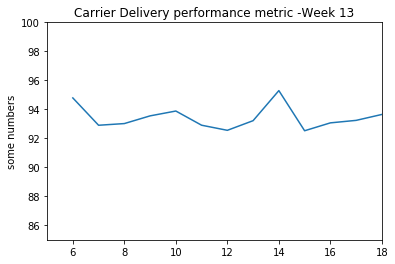

In [11]:
var = int(input("Please enter Week number: "))
print("you entered", var)
start=(var-14)
stop=(var-1)
plt.title('Carrier Delivery performance metric -Week 13')
plt.plot(xsum['PERFORMANCE'].iloc[start:stop])
plt.axis([start,stop,85,100])
plt.ylabel('some numbers')
plt.show()

# ANSWER a: PART 2

Step 6 : Here carrier-wise weekly number of parcels is shown

In [12]:
x1=dat.groupby(['Carrier_ID','Actual_Delivery_Week']).agg({'Shipment_ID':np.size,'Lateness':np.sum, 'Earliness': np.sum,'Delivery_beforeTime': np.sum,'Cust_comp_notlate':np.sum})
x1['pLateness']=(x1['Lateness']/x1['Shipment_ID'])
x1['pEarliness']=(x1['Earliness']/x1['Shipment_ID'])
x1['pDelivery_beforeTime']=x1['Delivery_beforeTime']/x1['Shipment_ID']
x1['pCust_comp_notlate']=(x1['Cust_comp_notlate']/(x1['Shipment_ID']*3))
x1['PERFORMANCE']=(40*(1-x1['pCust_comp_notlate'])+30*(x1['pDelivery_beforeTime'])+20*(1-x1['pLateness'])+10*(1-x1['pEarliness']))
x1.sort_values(['PERFORMANCE'], ascending=[1])   
x2=x1['PERFORMANCE'].unstack()
x2 = x2[x2.columns[start:stop]]
x2['wow']=x2[stop]-x2[stop-1]
print(x2)

Actual_Delivery_Week          6          7          8          9         10  \
Carrier_ID                                                                    
GNU LOGISTICS         94.148148  92.790698  94.609929  92.160494  92.810458   
INTERBOX              98.627451  92.500000  91.449275  91.944444  93.953488   
SPEEDY                96.923077  96.410256  96.736111  96.466667  98.490566   
STARPARCEL            89.523810  90.101010  94.166667  88.611111  93.680556   
VANDELAY              94.017094  90.909091  90.377358  95.517241  93.202614   
X                     95.619048  95.789474  91.612903  95.505051  90.980392   

Actual_Delivery_Week         11         12         13         14         15  \
Carrier_ID                                                                    
GNU LOGISTICS         91.666667  90.500000  89.037037  94.933333  88.119658   
INTERBOX              92.307692  93.537415  92.564103  97.976190  93.983740   
SPEEDY                96.126126  98.933333  96.6666

# ANSWER b

STEP 6: Here based on performance score the customer location is shown

In [13]:
x3=dat.groupby(['Customer_Location_ID']).agg({'Shipment_ID':np.size,'Lateness':np.sum, 'Earliness': np.sum,'Delivery_beforeTime': np.sum,'Cust_comp_notlate':np.sum})
x3['pLateness']=(x3['Lateness']/x3['Shipment_ID'])
x3['pEarliness']=(x3['Earliness']/x3['Shipment_ID'])
x3['pDelivery_beforeTime']=x3['Delivery_beforeTime']/x3['Shipment_ID']
x3['pCust_comp_notlate']=(x3['Cust_comp_notlate']/(x3['Shipment_ID']*3))
x3['PERFORMANCE']=(40*(1-x3['pCust_comp_notlate'])+30*(x3['pDelivery_beforeTime'])+20*(1-x3['pLateness'])+10*(1-x3['pEarliness']))
print('Minimum performance score', x3['PERFORMANCE'].min())
print('Maximum performance score', x3['PERFORMANCE'].max())
print(x3)

Minimum performance score 50.0
Maximum performance score 100.0
                      Shipment_ID  Lateness  Earliness  Delivery_beforeTime  \
Customer_Location_ID                                                          
A1                             13         1          1                   12   
A10                            12         0          0                   12   
A100                           16         1          2                   13   
A101                           10         2          1                    8   
A102                           15         0          0                   14   
A103                           17         0          2                   16   
A104                            6         0          0                    5   
A105                           17         0          0                   17   
A106                           18         3          2                   15   
A107                            4         0          0              

In [14]:
x3.to_csv('out.csv') #Save the output file